In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
def load_and_preprocess_image(path, size=(256, 256)):
    img = Image.open(path).convert('L').resize(size, Image.LANCZOS)
    return np.array(img, dtype=np.float32) / 255.0

# --- 클래스 경로 및 이름 정의 ---
all_image_paths = ['data/mona_lisa.jpg'] + sorted(glob.glob('data/sample*.jpg'))
class_names = [f"Mona Lisa {i} ({'Original' if i==0 else f'Parody_{i}'})" for i in range(len(all_image_paths))]

# --- 이미지 로드 ---
try:
    original_images = [load_and_preprocess_image(p) for p in all_image_paths]
    print(f"Successfully loaded {len(original_images)} images for {len(class_names)} classes.")
except FileNotFoundError as e:
    print(f"Error: Image file not found. Please check file paths. Details: {e}")


Successfully loaded 10 images for 10 classes.


In [3]:
# --- 3-1. 데이터 증강 파이프라인 ---
data_augmentation_pipeline = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05), # -18도 ~ +18도 사이 회전
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
], name="geometric_augmentation")

def augment_brightness_contrast(image):
    image_with_channel = image[..., tf.newaxis]
    image_aug = tf.image.random_brightness(image_with_channel, max_delta=0.15)
    image_aug = tf.image.random_contrast(image_aug, lower=0.8, upper=1.2)
    return tf.squeeze(image_aug)

# --- 3-2. 노이즈 함수 정의 (사용자 코드와 동일) ---
def add_noise_snr_np(image, snr_db):
    signal_power = np.mean(np.square(image))
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise_sigma = np.sqrt(noise_power)
    noise = np.random.normal(0, noise_sigma, image.shape).astype(np.float32)
    return np.clip(image + noise, 0.0, 1.0).astype(np.float32)

def add_salt_and_pepper_noise(image, amount=0.05, salt_vs_pepper=0.5):
    noisy_image = np.copy(image)
    num_salt = np.ceil(amount * image.size * salt_vs_pepper).astype(int)
    coords = tuple(np.random.randint(0, i-1, num_salt) for i in image.shape)
    noisy_image[coords] = 1.0
    num_pepper = np.ceil(amount * image.size * (1. - salt_vs_pepper)).astype(int)
    coords = tuple(np.random.randint(0, i-1, num_pepper) for i in image.shape)
    noisy_image[coords] = 0.0
    return noisy_image

def add_burst_noise(image, burst_size_factor=0.2, intensity=0.8):
    noisy_image = np.copy(image)
    h, w = image.shape
    burst_h, burst_w = int(h * burst_size_factor), int(w * burst_size_factor)
    if h <= burst_h or w <= burst_w: return noisy_image # prevent error
    start_y = np.random.randint(0, h - burst_h)
    start_x = np.random.randint(0, w - burst_w)
    burst_noise = np.random.normal(0, intensity, (burst_h, burst_w)).astype(np.float32)
    burst_area = noisy_image[start_y:start_y+burst_h, start_x:start_x+burst_w]
    noisy_area = np.clip(burst_area + burst_noise, 0.0, 1.0)
    noisy_image[start_y:start_y+burst_h, start_x:start_x+burst_w] = noisy_area
    return noisy_image

print("All functions are defined.")


All functions are defined.


2025-09-30 14:42:21.563728: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-09-30 14:42:21.563748: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-30 14:42:21.563766: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-30 14:42:21.563800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-30 14:42:21.563813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
def create_multitask_dataset_augmented(images, class_names_list, samples_per_class=100):
    X_noisy, y_clean, y_class = [], [], []
    noise_types = ['gaussian', 'salt_pepper', 'burst']
    total_samples = len(images) * samples_per_class
    
    with tqdm(total=total_samples, desc="Generating Dataset") as pbar:
        for class_idx, original_image in enumerate(images):
            for _ in range(samples_per_class):
                augmented_image = data_augmentation_pipeline(original_image[np.newaxis, ..., np.newaxis], training=True)
                augmented_image = np.squeeze(augmented_image)
                augmented_image = augment_brightness_contrast(augmented_image).numpy()
                clean_augmented_image = np.clip(augmented_image, 0.0, 1.0)
                noise_type = np.random.choice(noise_types)
                if noise_type == 'gaussian':
                    noisy_img = add_noise_snr_np(clean_augmented_image, snr_db=np.random.choice([-10, -20, -30]))
                elif noise_type == 'salt_pepper':
                    noisy_img = add_salt_and_pepper_noise(clean_augmented_image, amount=np.random.uniform(0.05, 0.15))
                else:
                    noisy_img = add_burst_noise(clean_augmented_image, burst_size_factor=np.random.uniform(0.2, 0.4), intensity=np.random.uniform(0.7, 1.0))
                
                X_noisy.append(noisy_img)
                y_clean.append(clean_augmented_image)
                y_class.append(class_idx)
                pbar.update(1)

    indices = np.arange(len(X_noisy))
    np.random.shuffle(indices)
    X_noisy = np.array(X_noisy)[indices][..., np.newaxis]
    y_clean = np.array(y_clean)[indices][..., np.newaxis]
    y_class = np.array(y_class)[indices]
    return X_noisy, y_clean, y_class

# ---!!! 여기가 핵심: 함수를 호출하여 X_data 변수를 실제로 생성 !!!---
X_data, y_restore_data, y_classify_data = create_multitask_dataset_augmented(
    original_images, class_names, samples_per_class=60
)
# ----------------------------------------------------------------

# --- 최종 결과 확인 ---
print("\n--- Dataset Creation Complete ---")
print(f"Input data shape (Noisy): X={X_data.shape}")
print(f"Target data shape (Clean): y_restore={y_restore_data.shape}")
print(f"Target data shape (Class): y_classify={y_classify_data.shape}")

Generating Dataset:   0%|          | 1/600 [00:00<01:48,  5.51it/s]2025-09-30 14:42:21.773528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-09-30 14:42:21.800848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-09-30 14:42:21.827400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-09-30 14:42:21.850546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-09-30 14:42:21.872346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
Generating Dataset:   1%|          | 6/600 [00:00<00:26, 22.84it/s]2025-09-30 14:42:21.895536: I m


--- Dataset Creation Complete ---
Input data shape (Noisy): X=(600, 256, 256, 1)
Target data shape (Clean): y_restore=(600, 256, 256, 1)
Target data shape (Class): y_classify=(600,)


In [5]:
# 4. 모델 설계  
from tensorflow.keras import layers, Model

def build_lightweight_multitask_unet(input_shape, num_classes):
    def conv_block(input_tensor, num_filters):
        x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    def decoder_block(input_tensor, skip_tensor, num_filters):
        x = layers.Conv2DTranspose(num_filters, 2, strides=2, padding='same')(input_tensor)
        x = layers.concatenate([x, skip_tensor])
        x = conv_block(x, num_filters)
        return x

    inputs = layers.Input(shape=input_shape)
    
    # Encoder 
    c1 = conv_block(inputs, 8)
    p1 = layers.MaxPooling2D(2)(c1)
    c2 = conv_block(p1, 16)
    p2 = layers.MaxPooling2D(2)(c2)
    c3 = conv_block(p2, 32)
    p3 = layers.MaxPooling2D(2)(c3)
    
    # Bottleneck
    b = conv_block(p3, 64)
    
    # Decoder
    d3 = decoder_block(b, c3, 32)   
    d2 = decoder_block(d3, c2, 16)
    d1 = decoder_block(d2, c1, 8)
    restoration_head = layers.Conv2D(1, 1, activation='sigmoid', name="restoration_output")(d1)
    
    # Classification Head (유닛 수 감소)
    flat = layers.GlobalAveragePooling2D()(b)
    dense1 = layers.Dense(64, activation='relu')(flat)
    dropout = layers.Dropout(0.5)(dense1)
    classification_head = layers.Dense(num_classes, activation='softmax', name="classification_output")(dropout)
    
    model = Model(inputs=inputs, outputs=[restoration_head, classification_head])
    return model

In [ ]:
# 5. 모델 컴파일 및 학습 (최종 안정화 버전)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Part 5: 모델 컴파일 및 학습 (멀티태스크 버전)

# --- 5-1. 모델 생성 ---
# build_lightweight_multitask_unet 함수는 그대로 사용
model = build_lightweight_multitask_unet(input_shape=(256, 256, 1), num_classes=len(class_names))

# --- 5-2. 학습률 스케줄러 및 콜백 정의 ---
initial_learning_rate = 1e-3 # 
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.98, staircase=True)

checkpoint_filepath = 'best_multitask_model.keras'
# 두 개의 validation metric을 모니터링하기 위해 val_loss를 기준으로 저장
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True) # restore_best_weights=True로 변경
    
# --- 5-3. 모델 컴파일 (멀티태스크) ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    # 두 개의 출력에 대한 손실 함수를 각각 지정
    loss={
        "restoration_output": "mean_absolute_error",
        "classification_output": "sparse_categorical_crossentropy"
    },
    # 각 손실의 중요도를 조절하는 가중치 
    loss_weights={
        "restoration_output": 0.9,
        "classification_output": 0.1
    },
    # 모니터링할 메트릭
    metrics={
        "classification_output": "accuracy"
    }
)
model.summary()

# --- 5-4. 모델 학습 ---
print("\n--- Training Multi-Task U-Net Model ---")
history = model.fit(
    X_data, # 입력: 노이즈 이미지
    { # 정답: 두 개의 출력을 딕셔너리 형태로 제공
        "restoration_output": y_restore_data,
        "classification_output": y_classify_data
    },
    epochs=500,
    batch_size=16,
    shuffle=True,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          80        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 8)          32        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 8)          0         ['batch_normalization[0][0

2025-09-30 14:42:39.515903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-09-30 14:42:39.673442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


30/30 [==============================] - 5s 121ms/step - loss: 0.3426 - restoration_output_loss: 0.2344 - classification_output_loss: 2.3991 - classification_output_accuracy: 0.1542 - val_loss: 1.0733 - val_restoration_output_loss: 0.6339 - val_classification_output_loss: 9.4209 - val_classification_output_accuracy: 0.1250
Epoch 2/500
30/30 [==============================] - 3s 105ms/step - loss: 0.2610 - restoration_output_loss: 0.1630 - classification_output_loss: 2.1231 - classification_output_accuracy: 0.2125 - val_loss: 1.8066 - val_restoration_output_loss: 0.5848 - val_classification_output_loss: 25.0208 - val_classification_output_accuracy: 0.1250
Epoch 3/500
30/30 [==============================] - 3s 106ms/step - loss: 0.2203 - restoration_output_loss: 0.1262 - classification_output_loss: 2.0089 - classification_output_accuracy: 0.2583 - val_loss: 1.2625 - val_restoration_output_loss: 0.5085 - val_classification_output_loss: 15.5900 - val_classification_output_accuracy: 0.1250

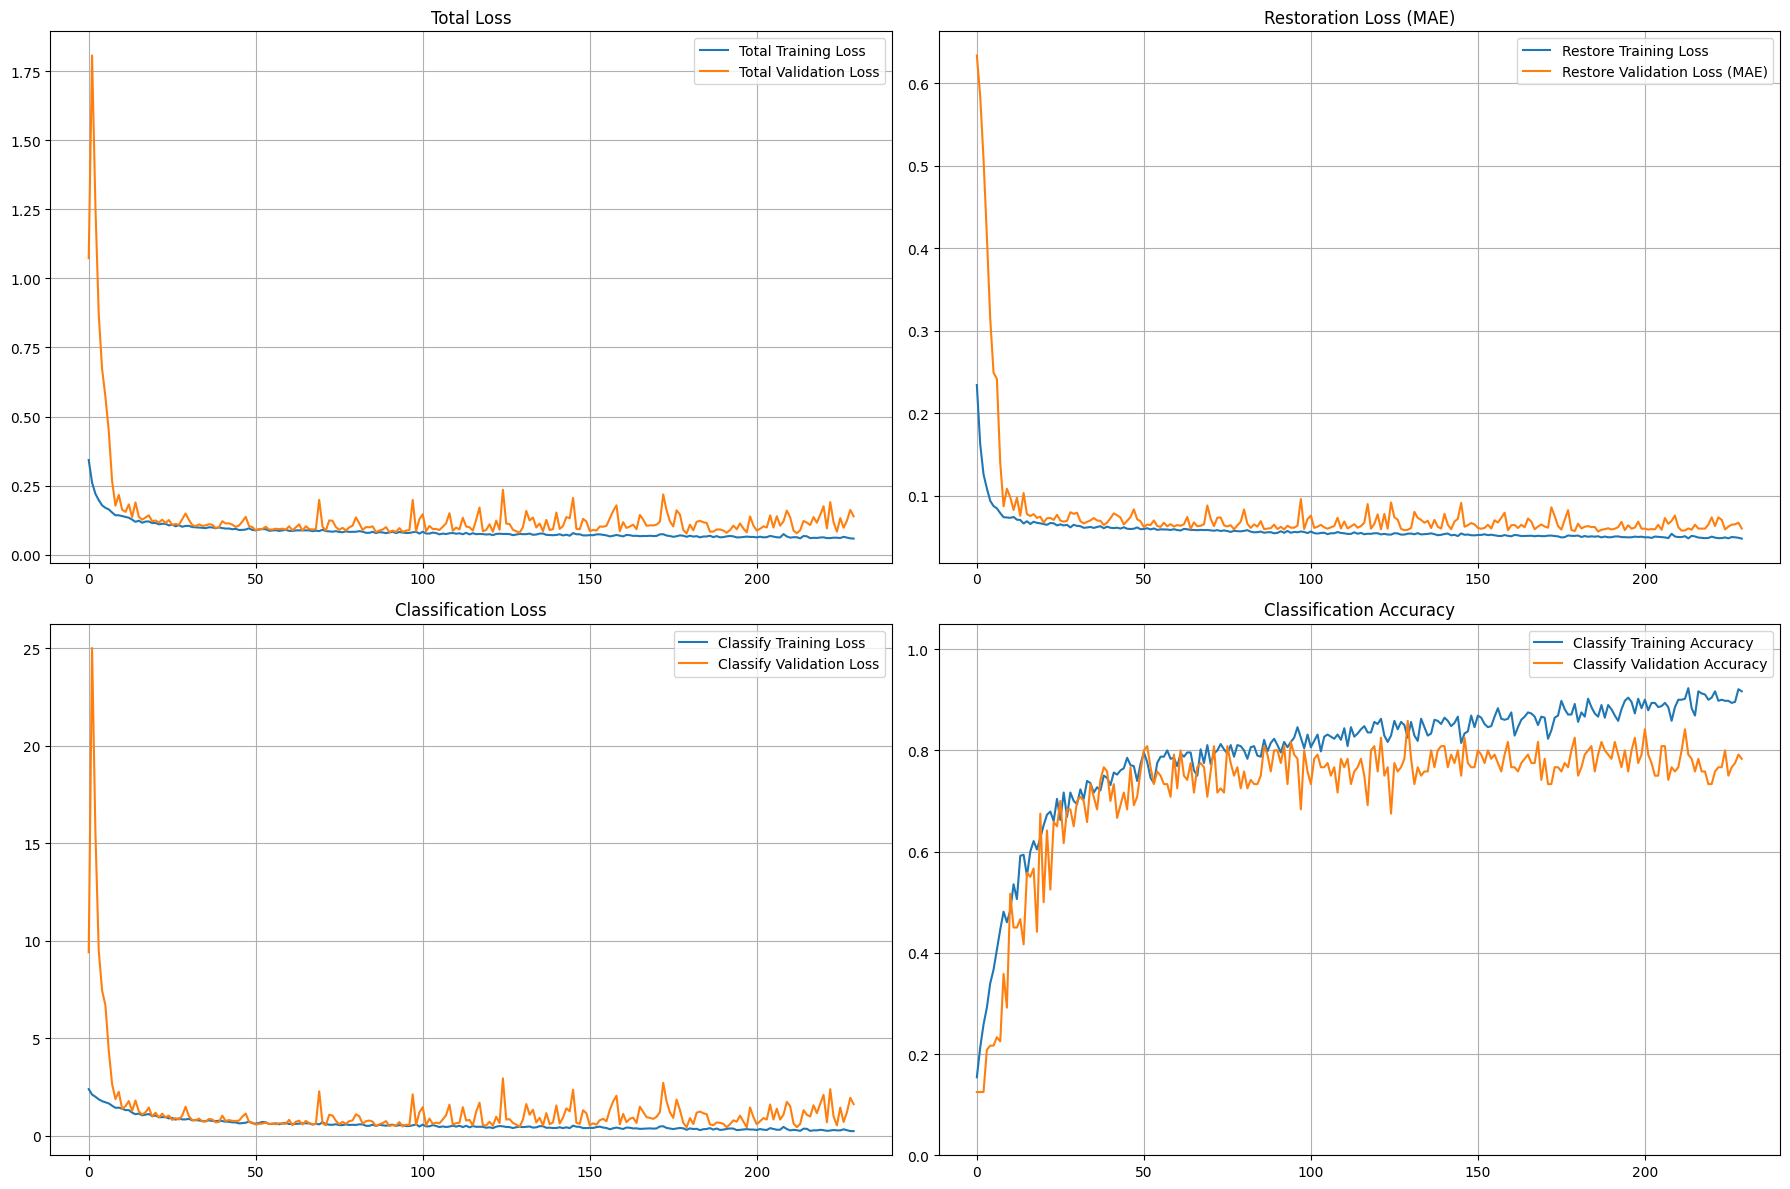


--- Loading the best multi-task model for final evaluation ---

--- Best Model Performance on Validation Set ---
Total Validation Loss: 0.076614
Validation Restoration Loss (MAE): 0.057306
Validation Classification Loss: 0.443472
Validation Classification Accuracy: 82.50%


In [7]:
# Part 6 & 7: 결과 시각화 및 최종 평가 (멀티태스크 버전)

# --- 학습 그래프 시각화 함수 ---
def plot_multitask_history(history_obj):
    # history.history 딕셔너리의 key 값들이 변경됨
    val_loss = history_obj.history['val_loss']
    val_restore_loss = history_obj.history['val_restoration_output_loss']
    val_classify_loss = history_obj.history['val_classification_output_loss']
    val_acc = history_obj.history['val_classification_output_accuracy']

    plt.figure(figsize=(18, 12))
    
    plt.subplot(2, 2, 1)
    plt.plot(history_obj.history['loss'], label='Total Training Loss')
    plt.plot(val_loss, label='Total Validation Loss')
    plt.title('Total Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(history_obj.history['restoration_output_loss'], label='Restore Training Loss')
    plt.plot(val_restore_loss, label='Restore Validation Loss (MAE)')
    plt.title('Restoration Loss (MAE)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(history_obj.history['classification_output_loss'], label='Classify Training Loss')
    plt.plot(val_classify_loss, label='Classify Validation Loss')
    plt.title('Classification Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(history_obj.history['classification_output_accuracy'], label='Classify Training Accuracy')
    plt.plot(val_acc, label='Classify Validation Accuracy')
    plt.title('Classification Accuracy')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_multitask_history(history)

# --- 최고 성능 모델 불러오기 및 최종 평가 ---
print("\n--- Loading the best multi-task model for final evaluation ---")
best_model = tf.keras.models.load_model('best_multitask_model.keras')

# Validation set 준비
split_index = int(len(X_data) * 0.8)
X_val = X_data[split_index:]
y_val_restore = y_restore_data[split_index:]
y_val_classify = y_classify_data[split_index:]

# 최종 평가
results = best_model.evaluate(
    X_val,
    {"restoration_output": y_val_restore, "classification_output": y_val_classify},
    verbose=0
)

print("\n--- Best Model Performance on Validation Set ---")
print(f"Total Validation Loss: {results[0]:.6f}")
print(f"Validation Restoration Loss (MAE): {results[1]:.6f}")
print(f"Validation Classification Loss: {results[2]:.6f}")
print(f"Validation Classification Accuracy: {results[3]*100:.2f}%")

1/1 [==============================] - 0s 227ms/step
[Gaussian Noise (SNR -30dB)] -> Model classified as: 'Mona Lisa 6 (Parody_6)' with 18.82% confidence.
[Salt-and-Pepper (amount=0.50)] -> Model classified as: 'Mona Lisa 0 (Original)' with 74.12% confidence.
[Burst Noise (size=0.60)] -> Model classified as: 'Mona Lisa 0 (Original)' with 59.55% confidence.


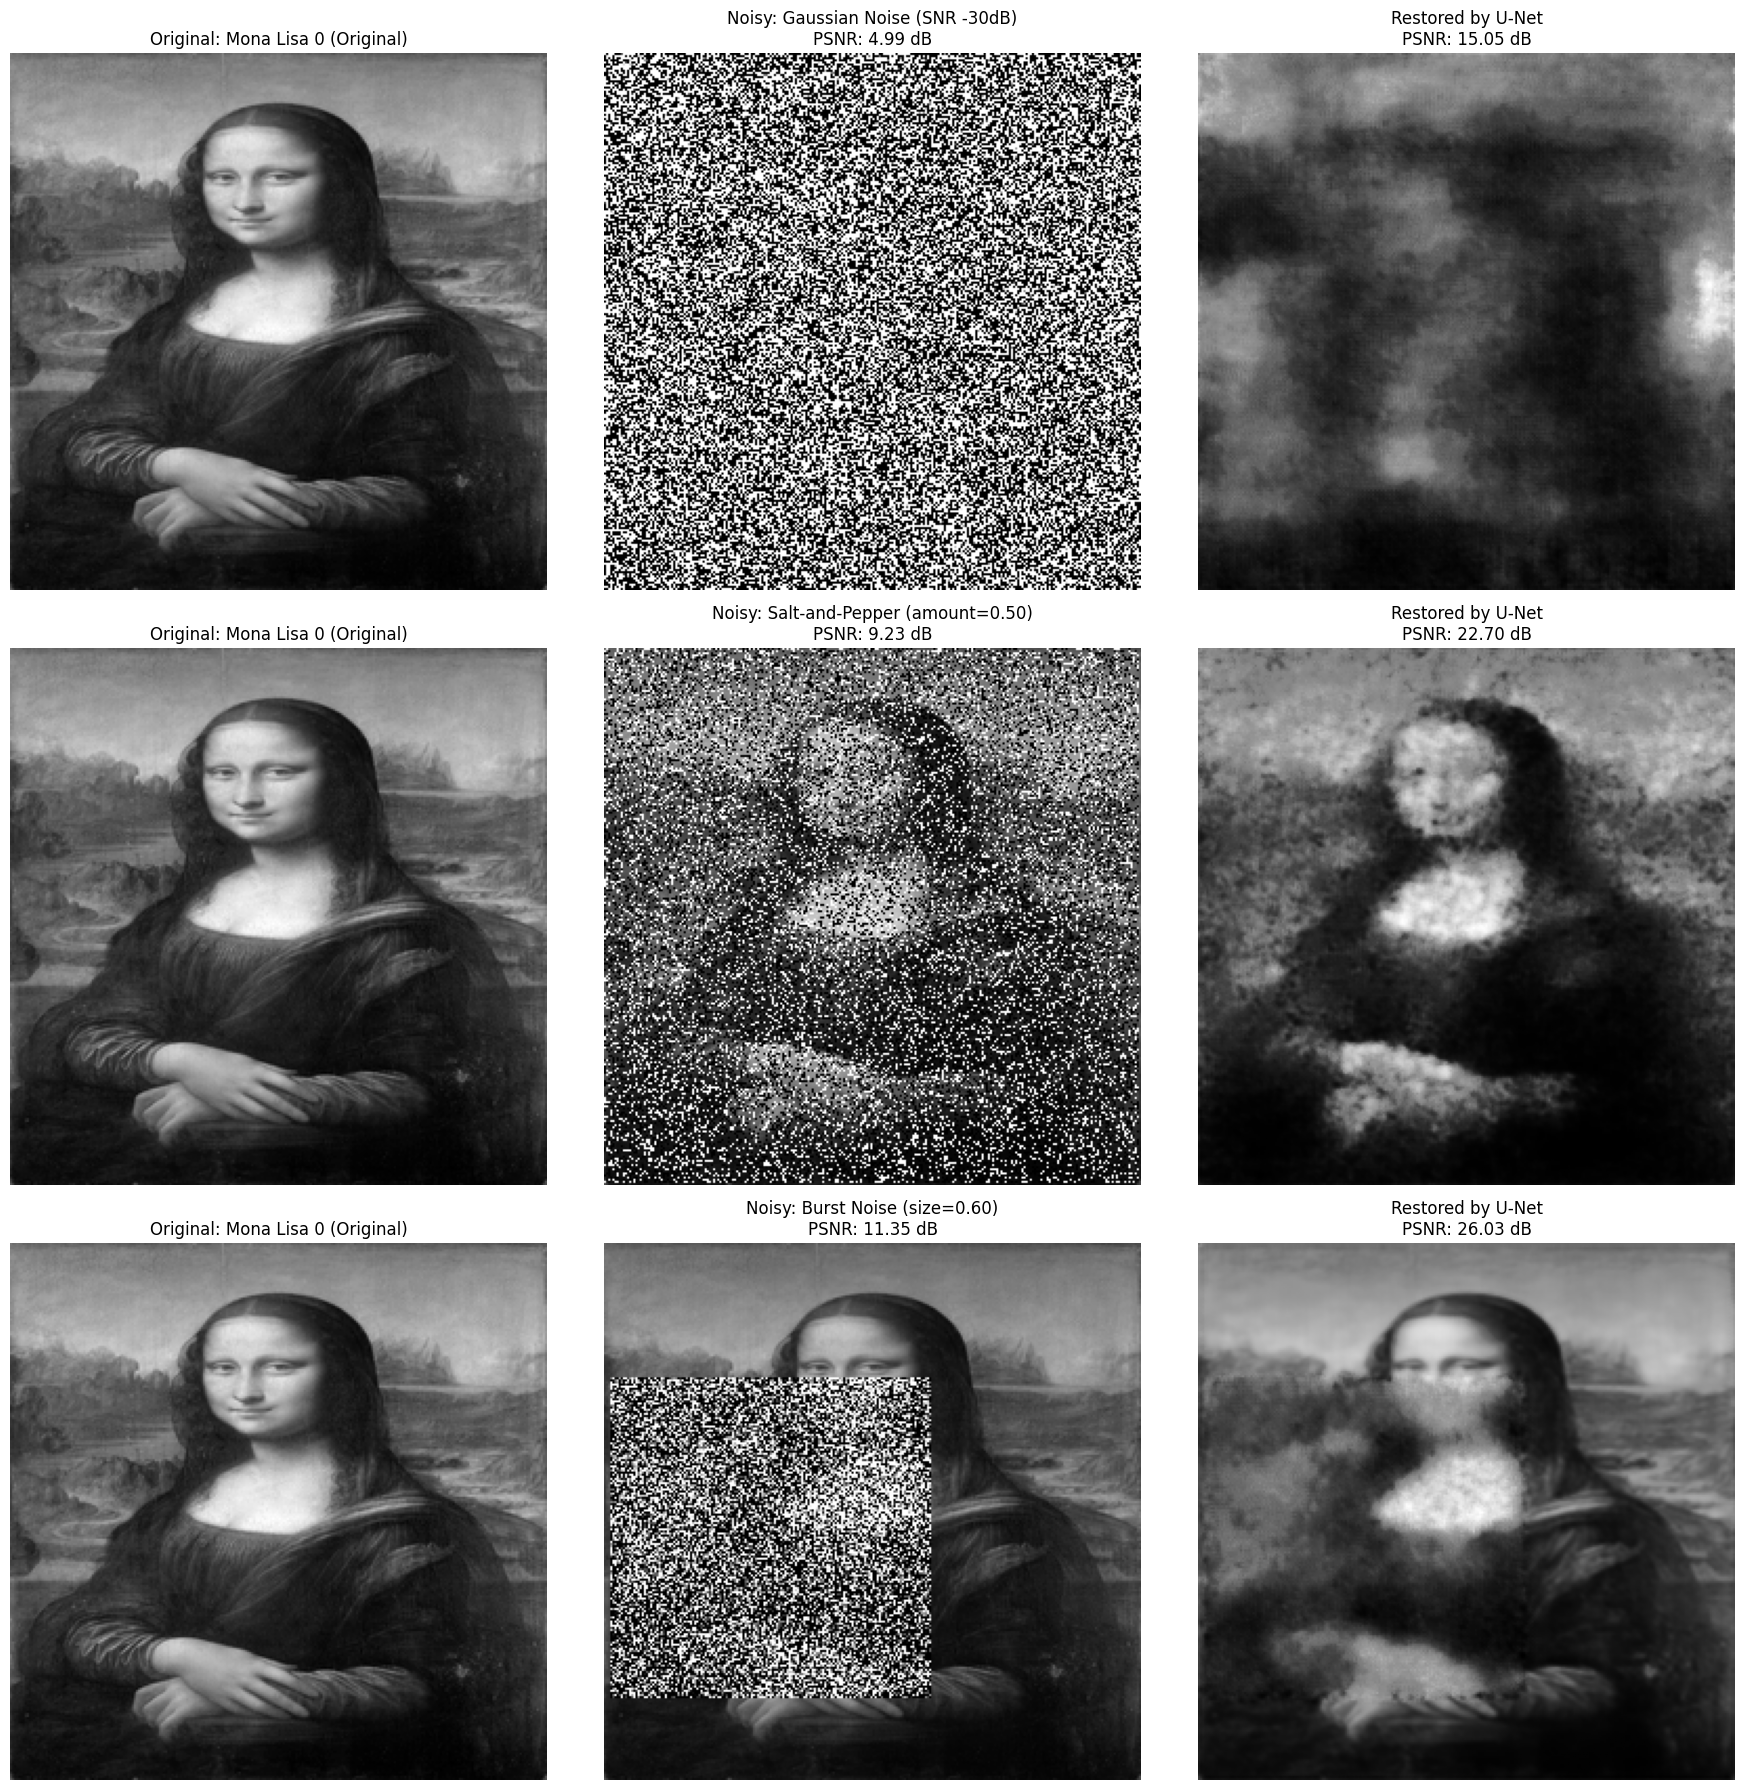

In [8]:
# Part 8-2: 보정된 노이즈 레벨로 최종 시각화 (calculate_psnr 함수 포함)

# --- PSNR 계산 함수를 여기에 추가/복구 ---
def calculate_psnr(img1, img2):
    """0~1 스케일 이미지 두 장의 PSNR을 계산합니다."""
    # 이미지가 텐서가 아닐 경우를 대비해 텐서로 변환
    img1 = tf.convert_to_tensor(img1, dtype=tf.float32)
    img2 = tf.convert_to_tensor(img2, dtype=tf.float32)
    return tf.image.psnr(img1[..., tf.newaxis], img2[..., tf.newaxis], max_val=1.0).numpy()
# -----------------------------------------

# --- 1. 시각화할 원본 이미지 선택 (동일) ---
sample_original_image = original_images[0]
sample_class_name = class_names[0]

# --- 2. 각 노이즈 유형별로 '매우 심한' 테스트 이미지 생성 ---
# 가우시안 노이즈 (기준점)
gaussian_noisy_img = add_noise_snr_np(sample_original_image, snr_db=-30)

# 솔트 앤 페퍼 노이즈 (픽셀의 50%를 손상)
sp_amount = 0.50
salt_pepper_noisy_img = add_salt_and_pepper_noise(sample_original_image, amount=sp_amount)

# 버스트 노이즈 (면적의 60%를 손상)
burst_size = 0.60
burst_noisy_img = add_burst_noise(sample_original_image, burst_size_factor=burst_size, intensity=1.0)

# 시각화를 위해 노이즈 이미지들을 리스트에 담기
noisy_images_to_test = [gaussian_noisy_img, salt_pepper_noisy_img, burst_noisy_img]

# --- 제목(title) 부분도 수동 설정 값으로 변경 ---
noise_titles = [
    f"Gaussian Noise (SNR -30dB)\nPSNR: {calculate_psnr(sample_original_image, gaussian_noisy_img):.2f} dB", 
    f"Salt-and-Pepper (amount={sp_amount:.2f})\nPSNR: {calculate_psnr(sample_original_image, salt_pepper_noisy_img):.2f} dB", 
    f"Burst Noise (size={burst_size:.2f})\nPSNR: {calculate_psnr(sample_original_image, burst_noisy_img):.2f} dB"
]

# --- 3. 모델로 복원 수행 (동일) ---
input_tensors = np.array(noisy_images_to_test)[..., np.newaxis]
restored_outputs, classification_outputs = best_model.predict(input_tensors)
restored_images = np.squeeze(restored_outputs)

# --- 4. 최종 결과 시각화 (동일) ---
num_noises = len(noisy_images_to_test)
plt.figure(figsize=(18, num_noises * 6))

for i in range(num_noises):
    plt.subplot(num_noises, 3, i * 3 + 1)
    plt.imshow(sample_original_image, cmap='gray')
    plt.title(f"Original: {sample_class_name}")
    plt.axis('off')

    plt.subplot(num_noises, 3, i * 3 + 2)
    plt.imshow(noisy_images_to_test[i], cmap='gray')
    plt.title(f"Noisy: {noise_titles[i]}")
    plt.axis('off')

    plt.subplot(num_noises, 3, i * 3 + 3)
    plt.imshow(restored_images[i], cmap='gray')
    plt.title(f"Restored by U-Net\nPSNR: {calculate_psnr(sample_original_image, restored_images[i]):.2f} dB")
    plt.axis('off')
    
    predicted_class_idx = np.argmax(classification_outputs[i])
    predicted_class_name = class_names[predicted_class_idx]
    confidence = np.max(classification_outputs[i]) * 100
    print(f"[{noise_titles[i].splitlines()[0]}] -> Model classified as: '{predicted_class_name}' with {confidence:.2f}% confidence.")

plt.tight_layout()
plt.show()


--- 분석 1: 노이즈 강도별 성능 곡선 생성 ---

Evaluating performance for gaussian noise...


Testing gaussian levels: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]



Evaluating performance for salt_pepper noise...


Testing salt_pepper levels: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]



Evaluating performance for burst noise...


Testing burst levels: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


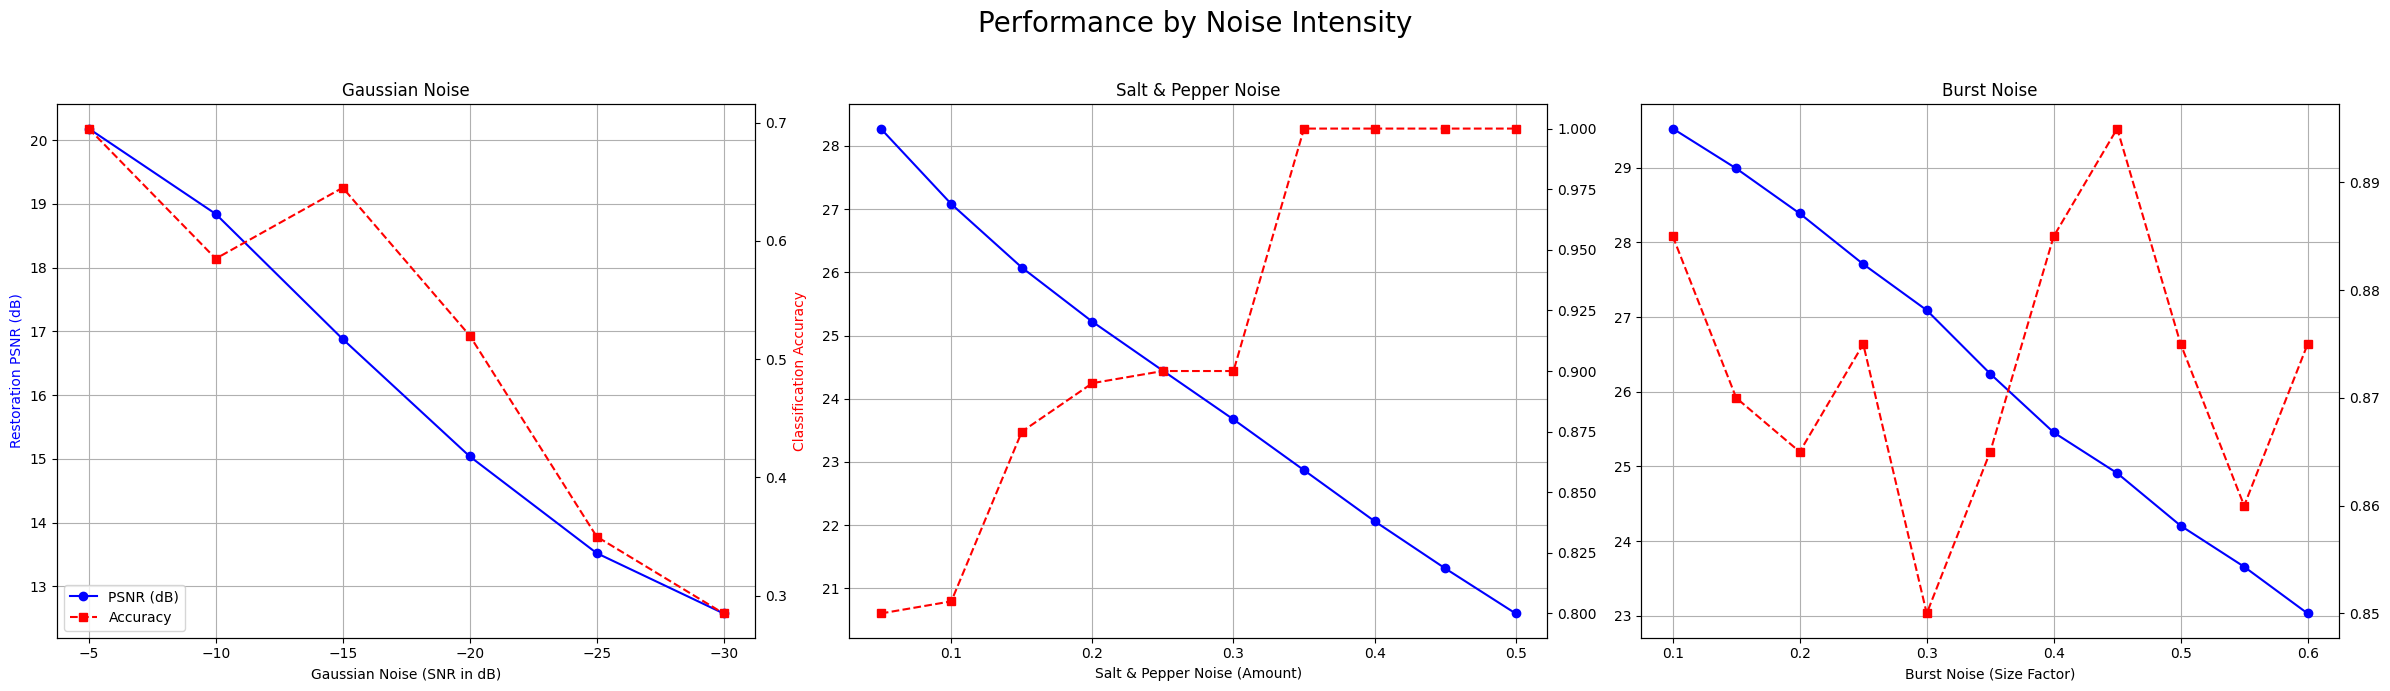

In [9]:
# Part 9: 노이즈 강도별 성능 곡선 분석
from tqdm import tqdm

print("\n--- 분석 1: 노이즈 강도별 성능 곡선 생성 ---")

# --- 1. 테스트할 노이즈 강도 레벨 정의 ---
gaussian_snr_levels = np.arange(-5, -31, -5) # [-5, -10, -15, -20, -25, -30]
sp_amount_levels = np.arange(0.05, 0.51, 0.05) # [0.05, 0.1, ..., 0.5]
burst_size_levels = np.arange(0.1, 0.61, 0.05) # [0.1, 0.15, ..., 0.6]

# 결과를 저장할 딕셔너리
performance_results = {
    'gaussian': {'levels': gaussian_snr_levels, 'psnr': [], 'accuracy': []},
    'salt_pepper': {'levels': sp_amount_levels, 'psnr': [], 'accuracy': []},
    'burst': {'levels': burst_size_levels, 'psnr': [], 'accuracy': []},
}

# --- 2. 각 노이즈 유형 및 강도별로 성능 측정 ---
num_test_samples_per_class = 20 # 테스트셋 크기 (클래스당 샘플 수)

for noise_type, data in performance_results.items():
    print(f"\nEvaluating performance for {noise_type} noise...")
    
    for level in tqdm(data['levels'], desc=f"Testing {noise_type} levels"):
        # a. 현재 레벨의 노이즈로 테스트셋 생성
        X_test, y_restore_test, y_classify_test = [], [], []
        for class_idx, original_img in enumerate(original_images):
            for _ in range(num_test_samples_per_class):
                if noise_type == 'gaussian':
                    noisy_img = add_noise_snr_np(original_img, snr_db=level)
                elif noise_type == 'salt_pepper':
                    noisy_img = add_salt_and_pepper_noise(original_img, amount=level)
                elif noise_type == 'burst':
                    noisy_img = add_burst_noise(original_img, burst_size_factor=level, intensity=1.0)
                
                X_test.append(noisy_img)
                y_restore_test.append(original_img)
                y_classify_test.append(class_idx)

        X_test = np.array(X_test)[..., np.newaxis]
        y_restore_test = np.array(y_restore_test)[..., np.newaxis]
        y_classify_test = np.array(y_classify_test)
        
        # b. 모델 예측 수행
        restored_outputs, classification_outputs = best_model.predict(X_test, verbose=0)
        
        # c. 복원 성능(PSNR) 계산
        avg_psnr = tf.image.psnr(y_restore_test, restored_outputs, max_val=1.0).numpy().mean()
        data['psnr'].append(avg_psnr)
        
        # d. 분류 성능(Accuracy) 계산
        predicted_classes = np.argmax(classification_outputs, axis=1)
        accuracy = np.mean(predicted_classes == y_classify_test)
        data['accuracy'].append(accuracy)

# --- 3. 성능 곡선 시각화 ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Performance by Noise Intensity', fontsize=20)

# 가우시안 노이즈
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.plot(performance_results['gaussian']['levels'], performance_results['gaussian']['psnr'], 'o-', color='b', label='PSNR (dB)')
ax1_twin.plot(performance_results['gaussian']['levels'], performance_results['gaussian']['accuracy'], 's--', color='r', label='Accuracy')
ax1.set_xlabel('Gaussian Noise (SNR in dB)')
ax1.set_ylabel('Restoration PSNR (dB)', color='b')
ax1_twin.set_ylabel('Classification Accuracy', color='r')
ax1.set_title('Gaussian Noise')
ax1.grid(True)
ax1.invert_xaxis() # SNR은 낮을수록 노이즈가 심하므로 x축 반전
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1_twin.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

# 솔트 앤 페퍼 노이즈
ax2 = axes[1]
ax2_twin = ax2.twinx()
ax2.plot(performance_results['salt_pepper']['levels'], performance_results['salt_pepper']['psnr'], 'o-', color='b', label='PSNR (dB)')
ax2_twin.plot(performance_results['salt_pepper']['levels'], performance_results['salt_pepper']['accuracy'], 's--', color='r', label='Accuracy')
ax2.set_xlabel('Salt & Pepper Noise (Amount)')
ax2.set_title('Salt & Pepper Noise')
ax2.grid(True)

# 버스트 노이즈
ax3 = axes[2]
ax3_twin = ax3.twinx()
ax3.plot(performance_results['burst']['levels'], performance_results['burst']['psnr'], 'o-', color='b', label='PSNR (dB)')
ax3_twin.plot(performance_results['burst']['levels'], performance_results['burst']['accuracy'], 's--', color='r', label='Accuracy')
ax3.set_xlabel('Burst Noise (Size Factor)')
ax3.set_title('Burst Noise')
ax3.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- 분석 2: Confusion Matrix 생성 ---
4/4 [==============================] - 0s 77ms/step

--- Classification Report (Validation Set) ---
                        precision    recall  f1-score   support

Mona Lisa 0 (Original)       1.00      0.43      0.60         7
Mona Lisa 1 (Parody_1)       0.75      1.00      0.86        15
Mona Lisa 2 (Parody_2)       0.83      0.71      0.77         7
Mona Lisa 3 (Parody_3)       0.56      0.83      0.67        12
Mona Lisa 4 (Parody_4)       1.00      0.71      0.83        17
Mona Lisa 5 (Parody_5)       0.88      0.88      0.88         8
Mona Lisa 6 (Parody_6)       0.84      1.00      0.91        16
Mona Lisa 7 (Parody_7)       0.91      0.77      0.83        13
Mona Lisa 8 (Parody_8)       1.00      0.73      0.85        15
Mona Lisa 9 (Parody_9)       0.83      1.00      0.91        10

              accuracy                           0.82       120
             macro avg       0.86      0.81      0.81       120
          weighted avg       0.

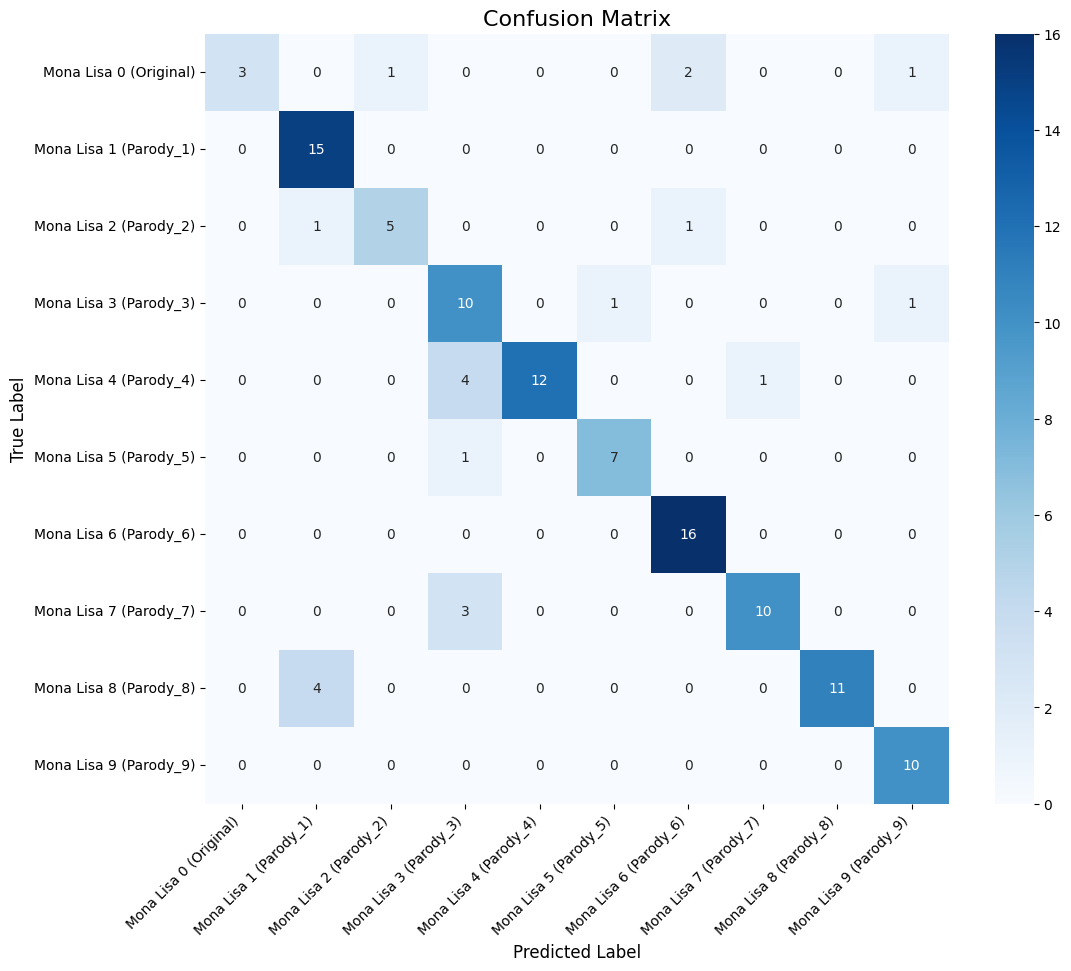

In [10]:
# Part 10: Confusion Matrix 분석

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n--- 분석 2: Confusion Matrix 생성 ---")

# Validation set 준비 (이미 이전 코드에 있음)
split_index = int(len(X_data) * 0.8)
X_val = X_data[split_index:]
y_val = y_classify_data[split_index:] # 분류 정답만 필요

# --- 1. Validation set에 대한 예측 수행 ---
# best_model 예측 결과에서 분류 헤드의 출력([1])만 사용
y_pred_probs = best_model.predict(X_val)[1] 
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- 2. Classification Report 출력 (각 클래스별 정밀도, 재현율 등) ---
print("\n--- Classification Report (Validation Set) ---")
# target_names에 이전에 정의한 class_names 리스트를 사용
print(classification_report(y_val, y_pred_classes, target_names=class_names))

# --- 3. Confusion Matrix 시각화 ---
print("\n--- Confusion Matrix (Validation Set) ---")
cm = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()